In [2]:
#filename = 'hdf5/9day.h5'
#filename = 'hdf5/superlong_2.h5'
#filename = 'hdf5/60hr.h5' #Format: 'hdf5/FileName.h5'
                                 #'hdf5' is the name of the folder that contains the hdf5 file named FileName, .h5 is
                                 #format of the file (like .txt or .csv)
a = 5

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
from itertools import combinations, combinations_with_replacement, permutations

import gm2
import trfp
import plotting_functions as plt2
import AnalysisHelper as helper
import helper_function_candidates as helper_old
import allantools
from IPython.display import clear_output
import os

Welcome to JupyROOT 6.22/02


In [4]:
path = os.path.abspath('ProbeDropPlots_Jonathan')

In [5]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':10, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in range(len(y)):
        Sum += y[i]
        if i % avgt == 0 and i > 0:
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def bin_vtm(vtm_df, autobin=True, start=None, end=None, dt=None):
    
    if autobin:
        dt = 1000
        start = np.ceil(vtm_df.index.values[0]/dt)*dt
        end = np.floor(vtm_df.index.values[-1]/dt)*dt
        
    bin_edges = np.arange(start, end+dt, dt)
    bin_centers = np.arange(start, end, dt)+dt/2
        
    bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bin_edges)).mean()
    bin_df.index = bin_centers
    return bin_df

def MovingAvg(x, bin_size):
    avg = np.array([])
    for i in np.arange(len(x) - bin_size + 1):
    #while (i <= len(x) - bin_size):
        Sum = 0
        j = 0
        for j in np.arange(bin_size):
        #while (j < bin_size):
            Sum += x[i + j]
            #j += 1
        avg = np.append(avg, Sum)
        #if(i % 86400 == 0):
            #print(str(i) + "iterations done")
        i +=1
    return avg/bin_size

def Drops(nProbes, nDrops):
    L = list(combinations(range(nProbes), nProbes - nDrops))
    N = len(L)
    drops = np.zeros((N ,nProbes))
    for i in range(N):
        for j in range(nProbes-nDrops):
            drops[i, L[i][j]] = 1
    return drops.astype('int')

def DropsToLabel(drops):
    label = "Dropped probes( "
    for i in range(len(drops)):
        if drops[i] == 0:
            label += str(i) +", "
    return label[:-2] + ")"

In [6]:
nProbes = 17
Binsize = 40
#helper.root_to_pandas([3956], prefix = r'//data1/newg2/DataProduction/Offline/ArtTFSDir/v9_21_05_dev/FieldPlainRootOutput_',\
#                      tr_run=True)

interp_df = pd.read_hdf('hdf5/superlong_1.h5')

In [7]:
nProbes = 17
Binsize = 40

rolling_windows = helper.calc_moment_df(interp_df).rolling(Binsize, min_periods=Binsize)
avgdMoment_df = rolling_windows.mean()

nEvents = len(np.delete(avgdMoment_df["tr,m1"].to_numpy(), np.arange(39)))
trm_undropped = np.zeros((nProbes, nEvents))
for i in range(nProbes):
    trm_undropped[i] = np.delete(avgdMoment_df["tr,m" + str(i+1)].to_numpy(), np.arange(39))
    T = np.delete(avgdMoment_df.index.to_numpy(), np.arange(39))

Finished calculating all moments for 252363 events.     


In [8]:
#One drop posib.
PossibleDropsN = np.flip(Drops(17,1), axis = 0)

In [9]:
nDrops = 1

trm_dropped = np.zeros((len(PossibleDropsN), nProbes, nEvents))
for i in range(len(PossibleDropsN)):
    rolling_windows = helper.calc_moment_df(interp_df, trolleyProbes = PossibleDropsN[i])\
    .rolling(Binsize, min_periods = Binsize)
    moment_df_dropped = rolling_windows.mean()
    for j in range(nProbes):
        trm_dropped[i,j] = np.delete(moment_df_dropped["tr,m" + str(j+1)].to_numpy(), np.arange(39))

Finished calculating all moments for 252363 events.    
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.    
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.    
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.     
Finished calculating all moments for 252363 events.    


In [10]:
tr_phi = moment_df_dropped['tr_phi'].to_numpy()[39:]

[99.03 99.03 99.03 ... 99.03 99.03 99.03]


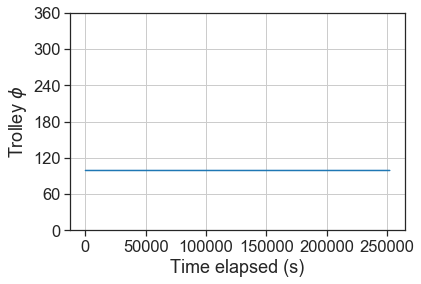

In [11]:
print(tr_phi)
plt.plot(T-T[0], tr_phi)
plt.xlabel('Time elapsed (s)')
plt.ylabel(r'Trolley $\phi$')
plt.yticks(np.linspace(0,360, 7))
plt.grid()
plt.show()

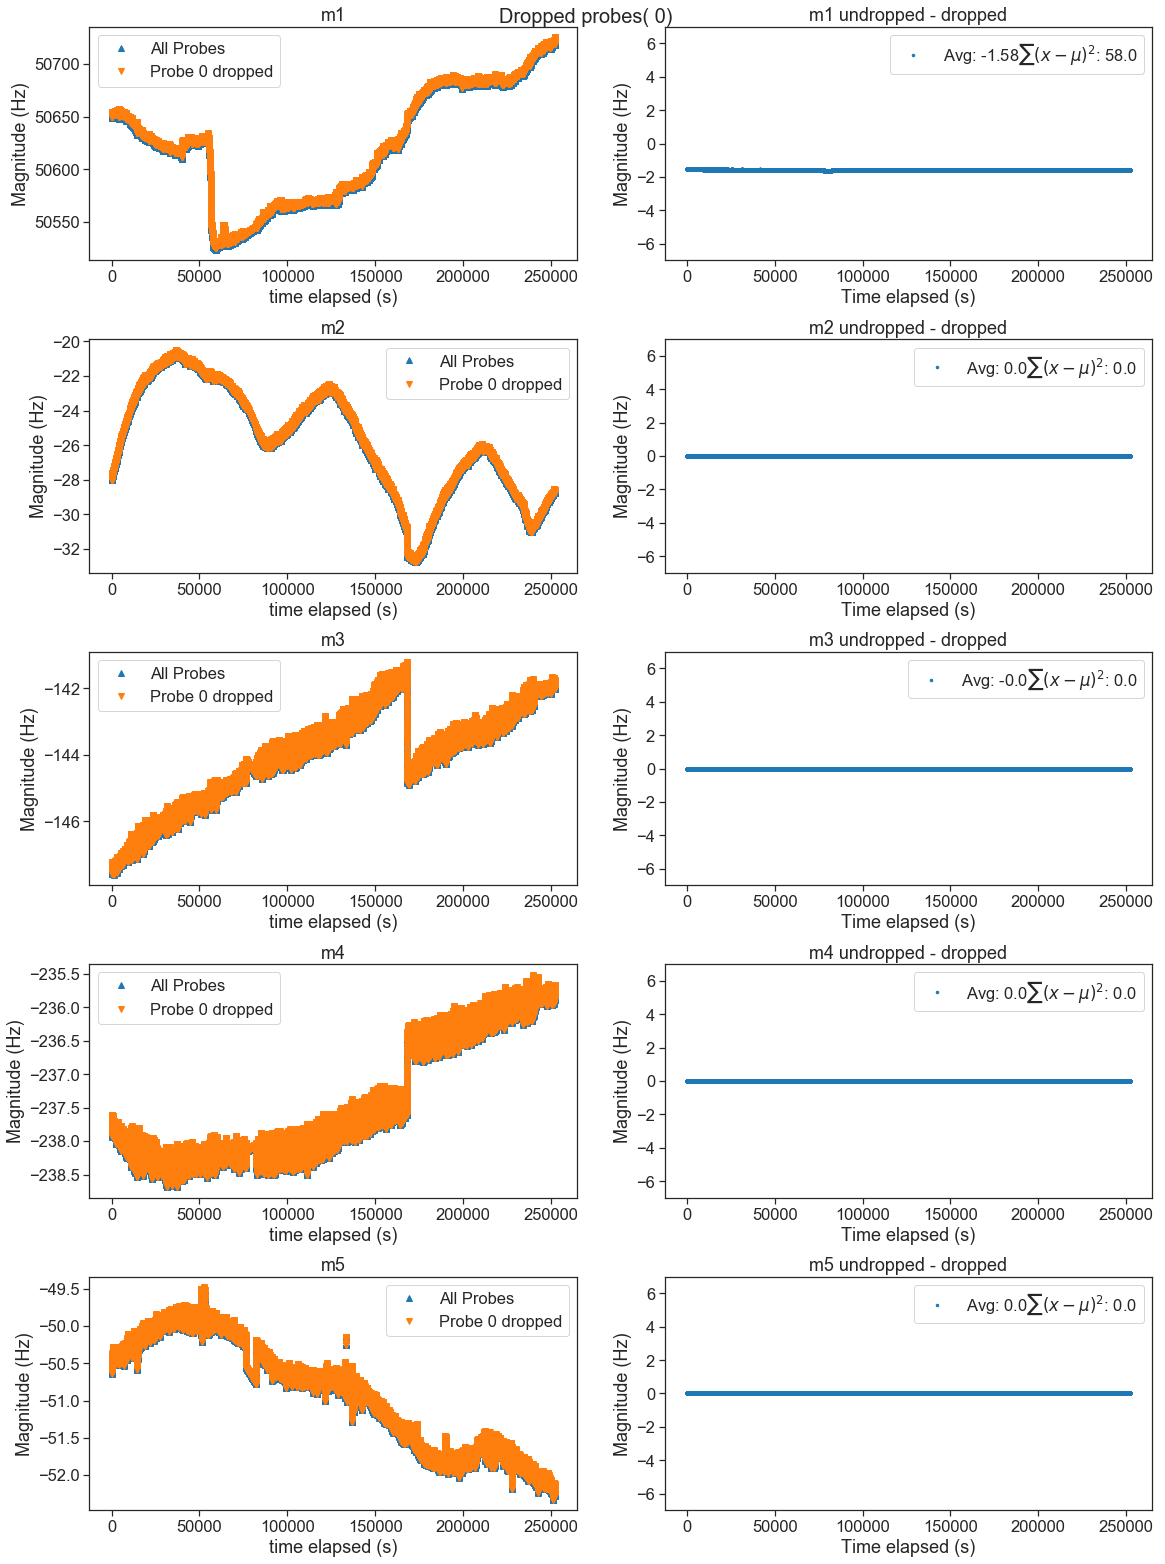

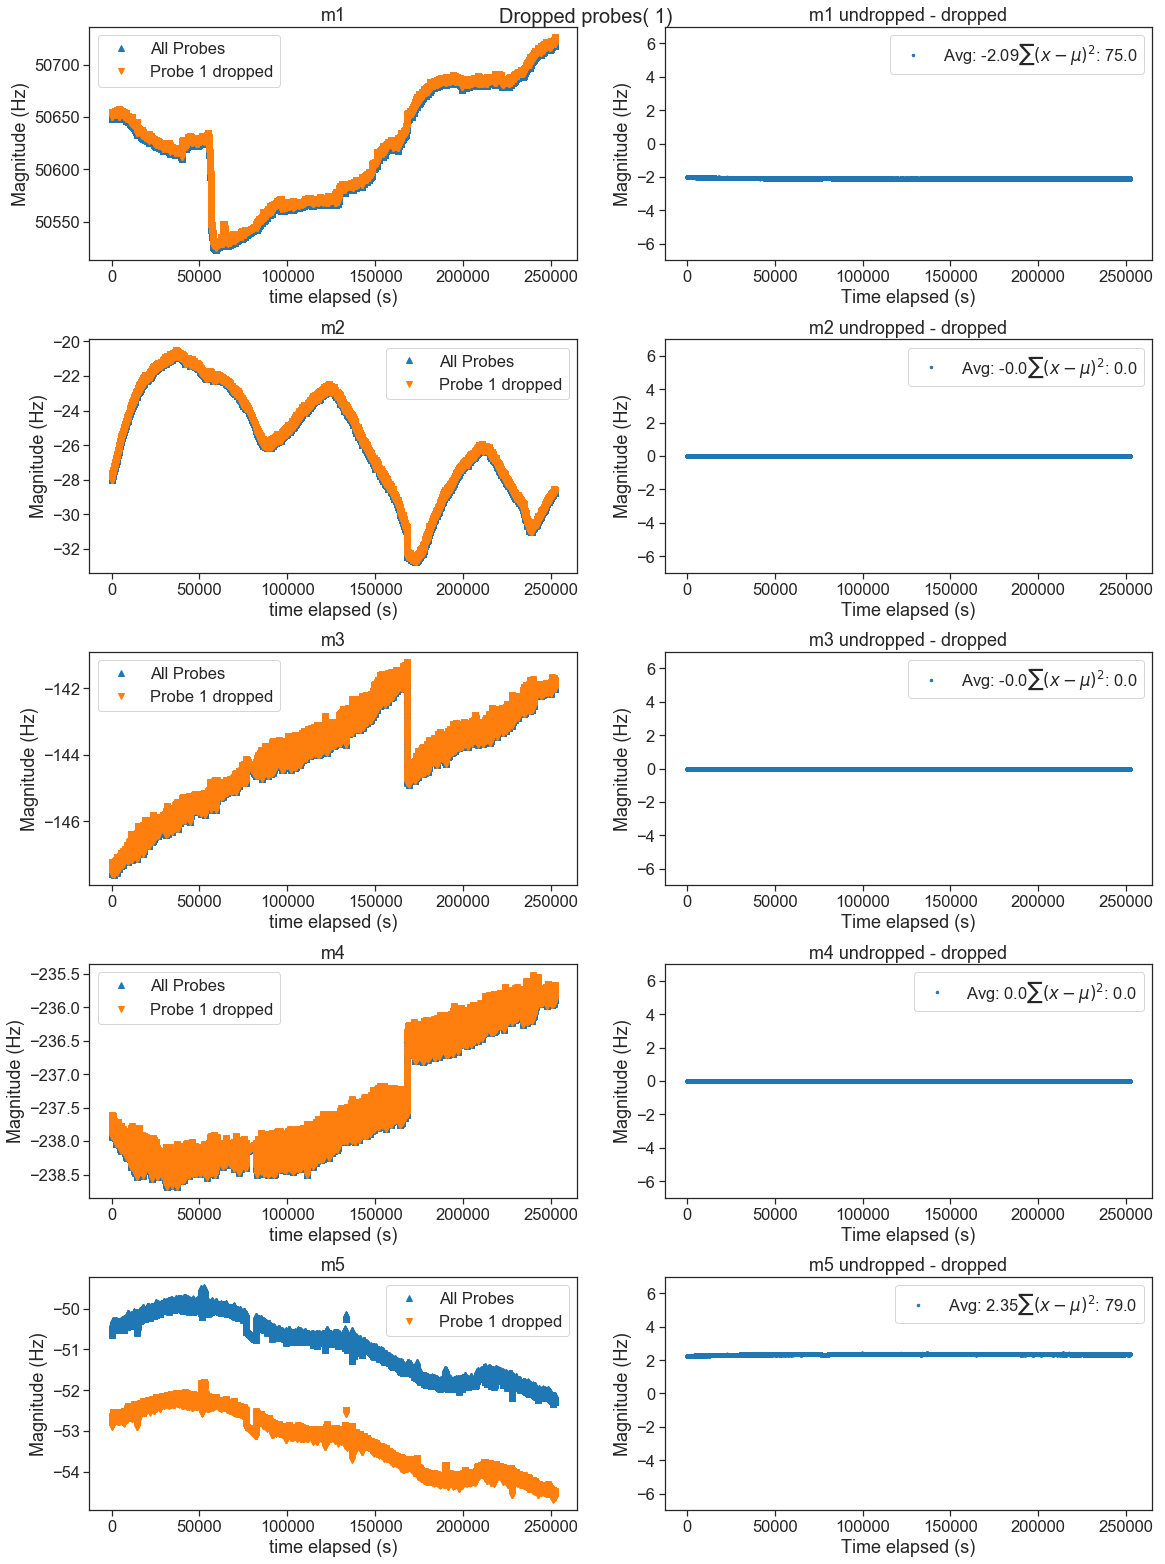

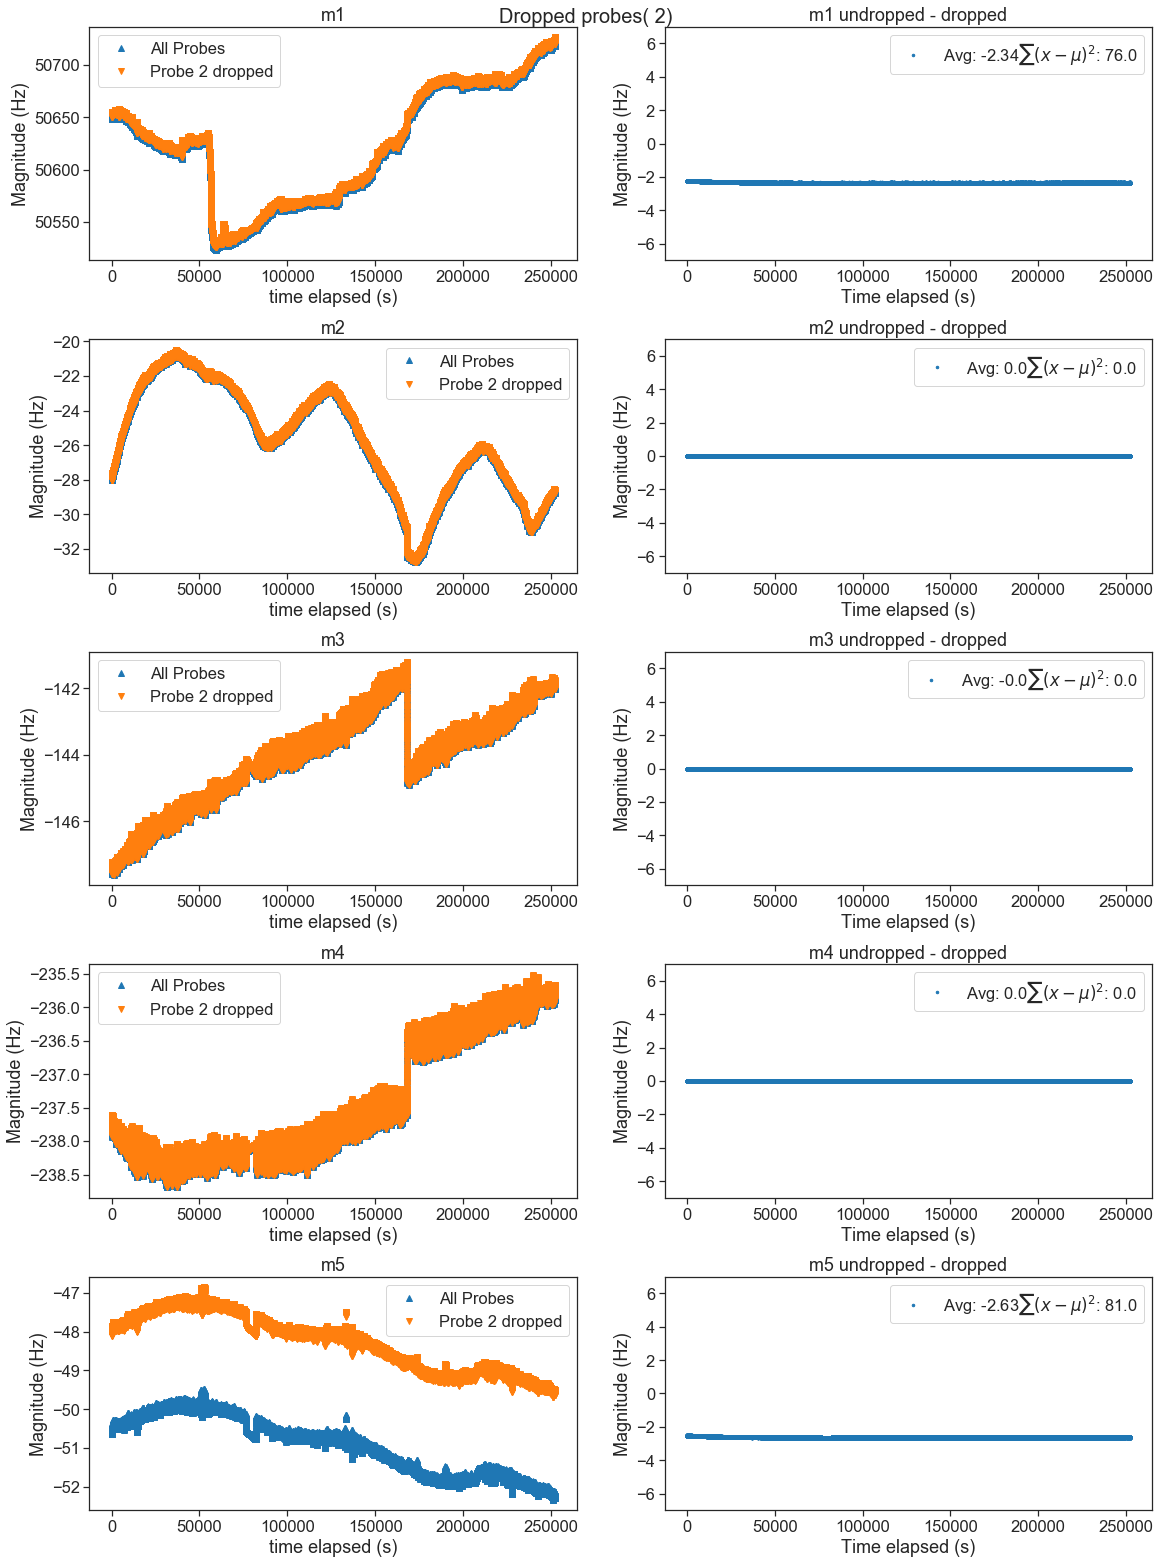

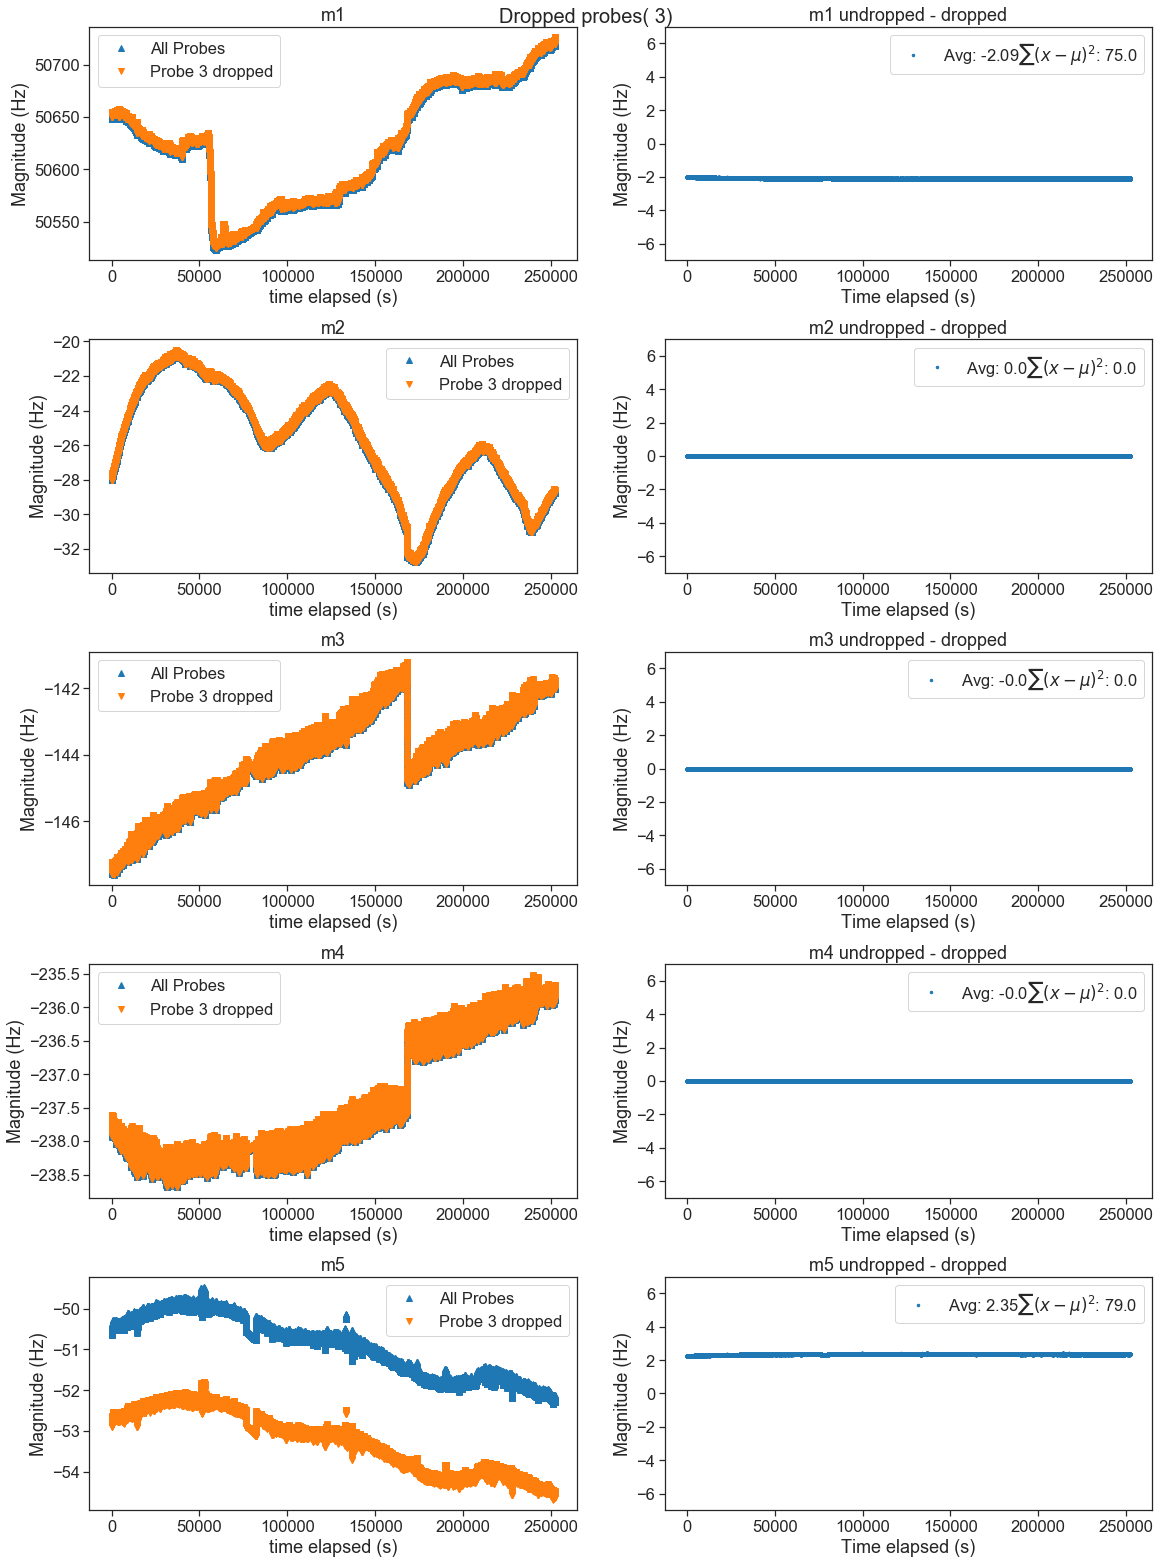

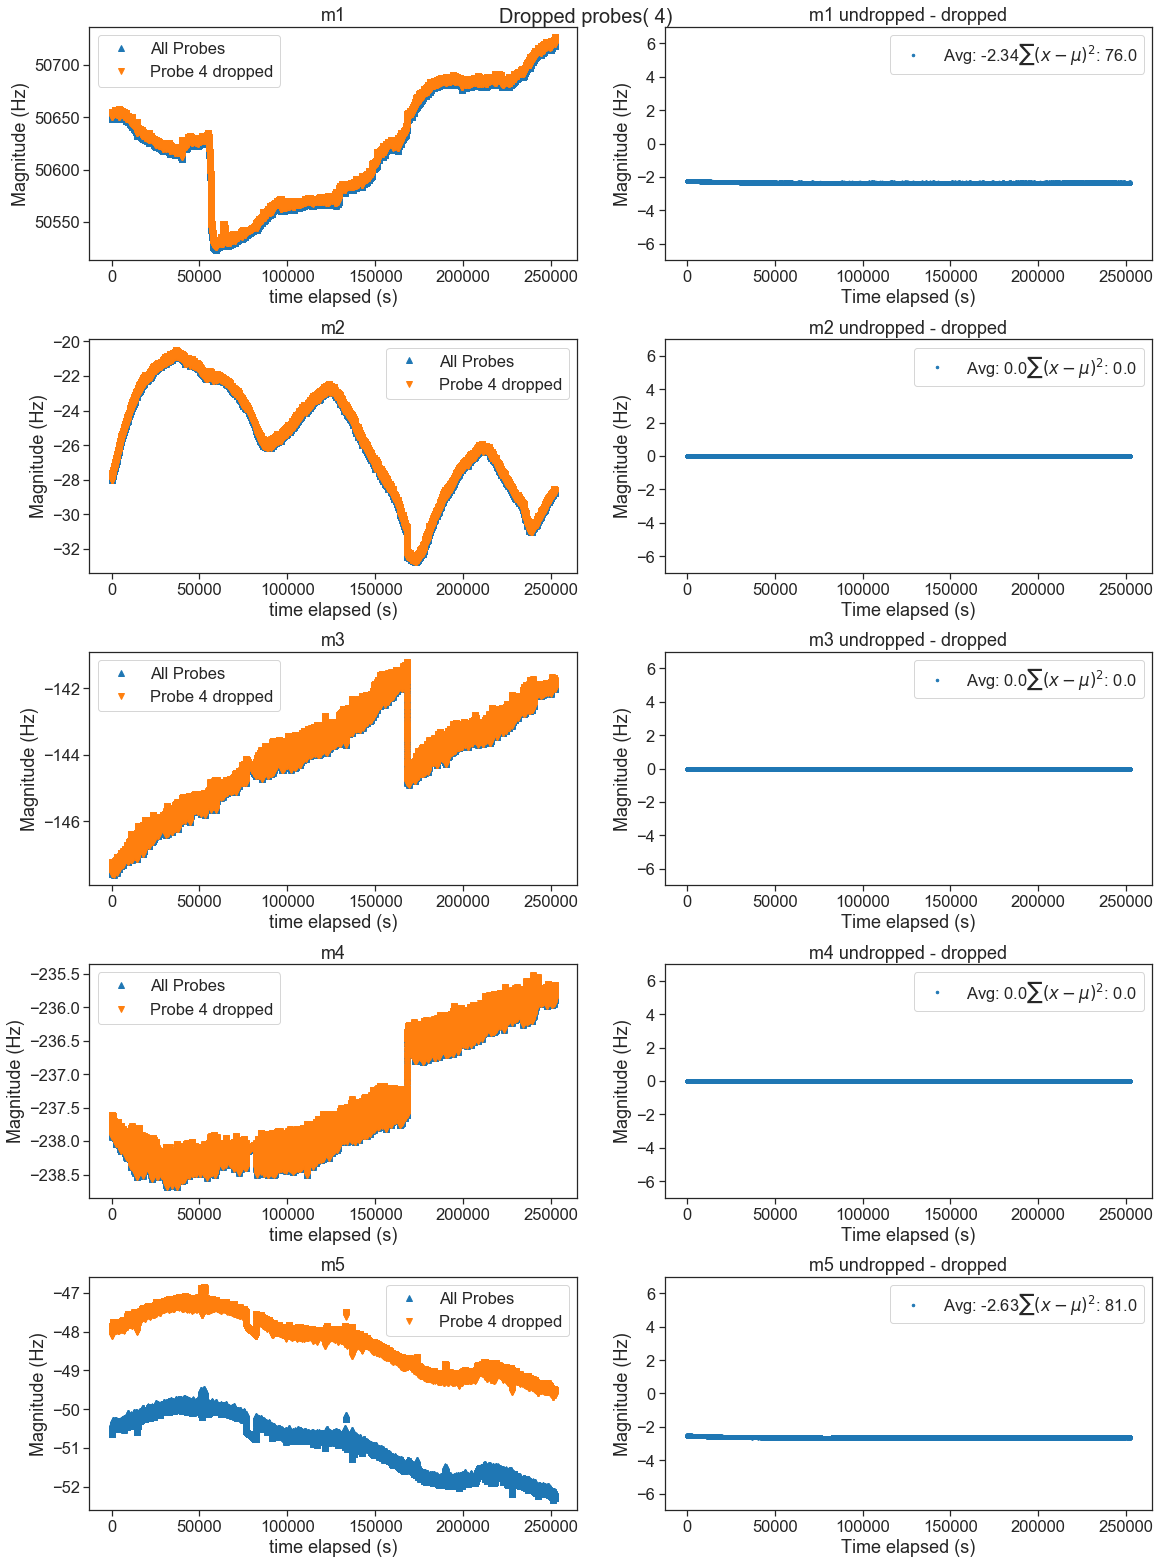

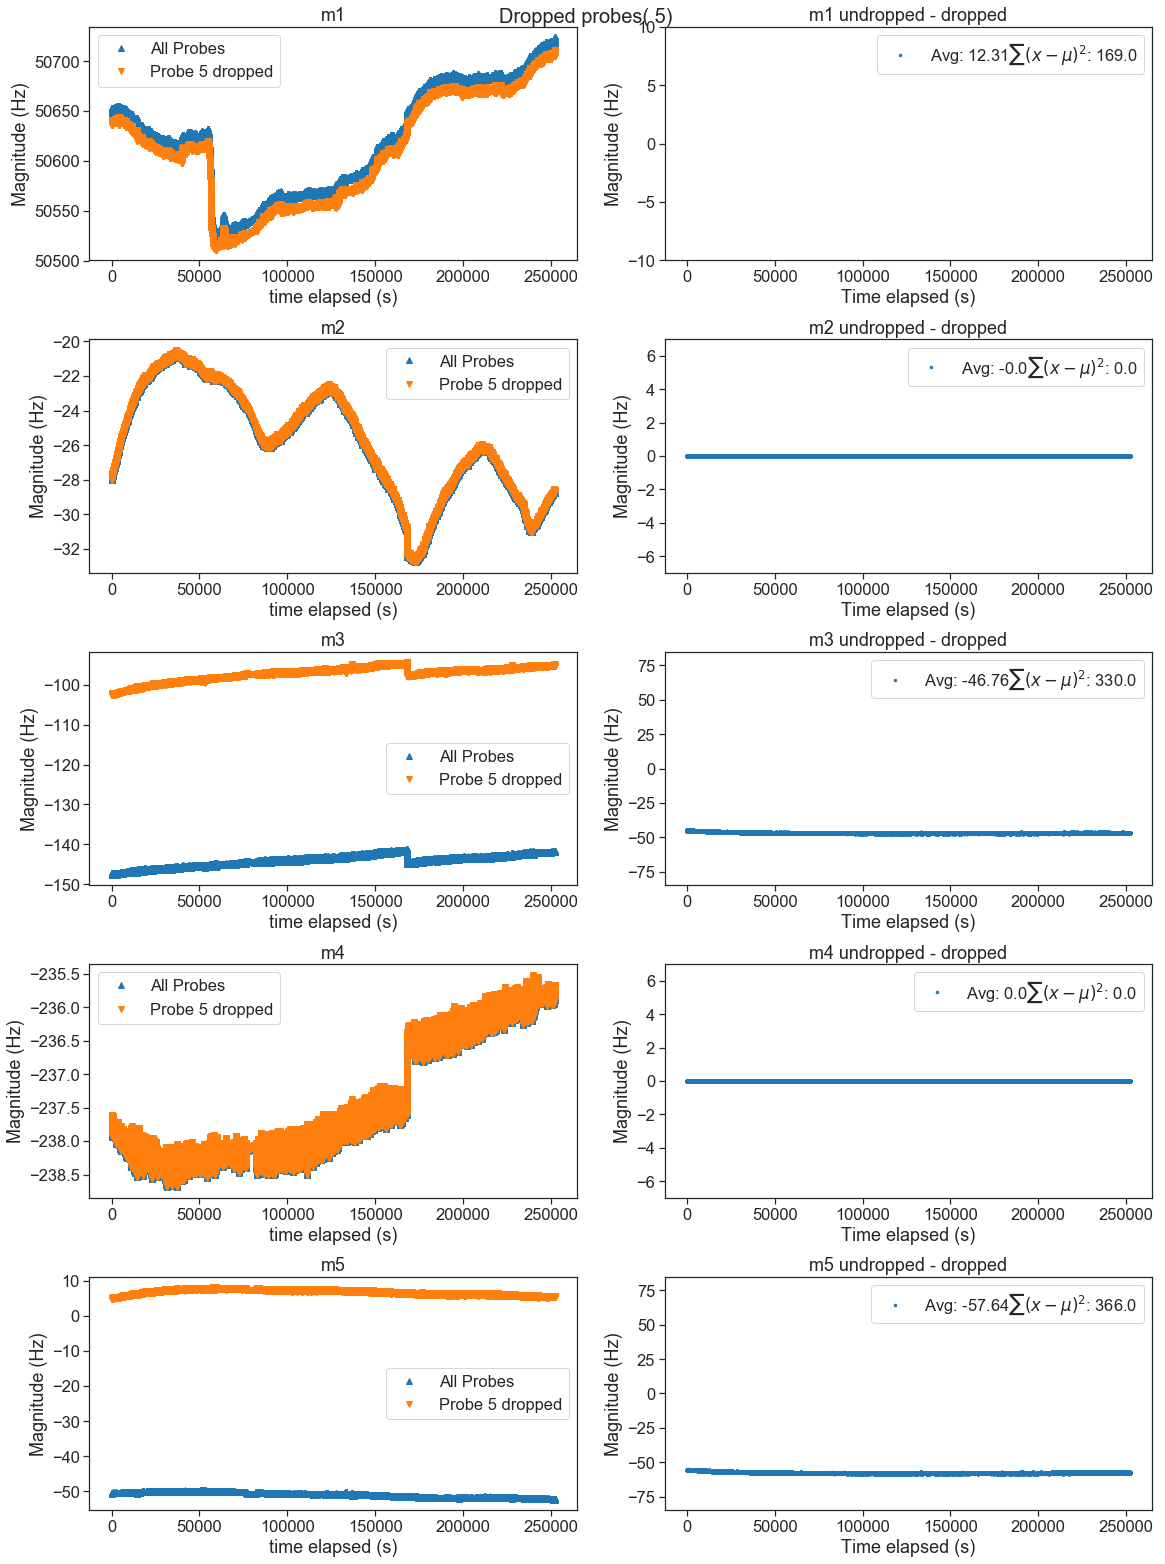

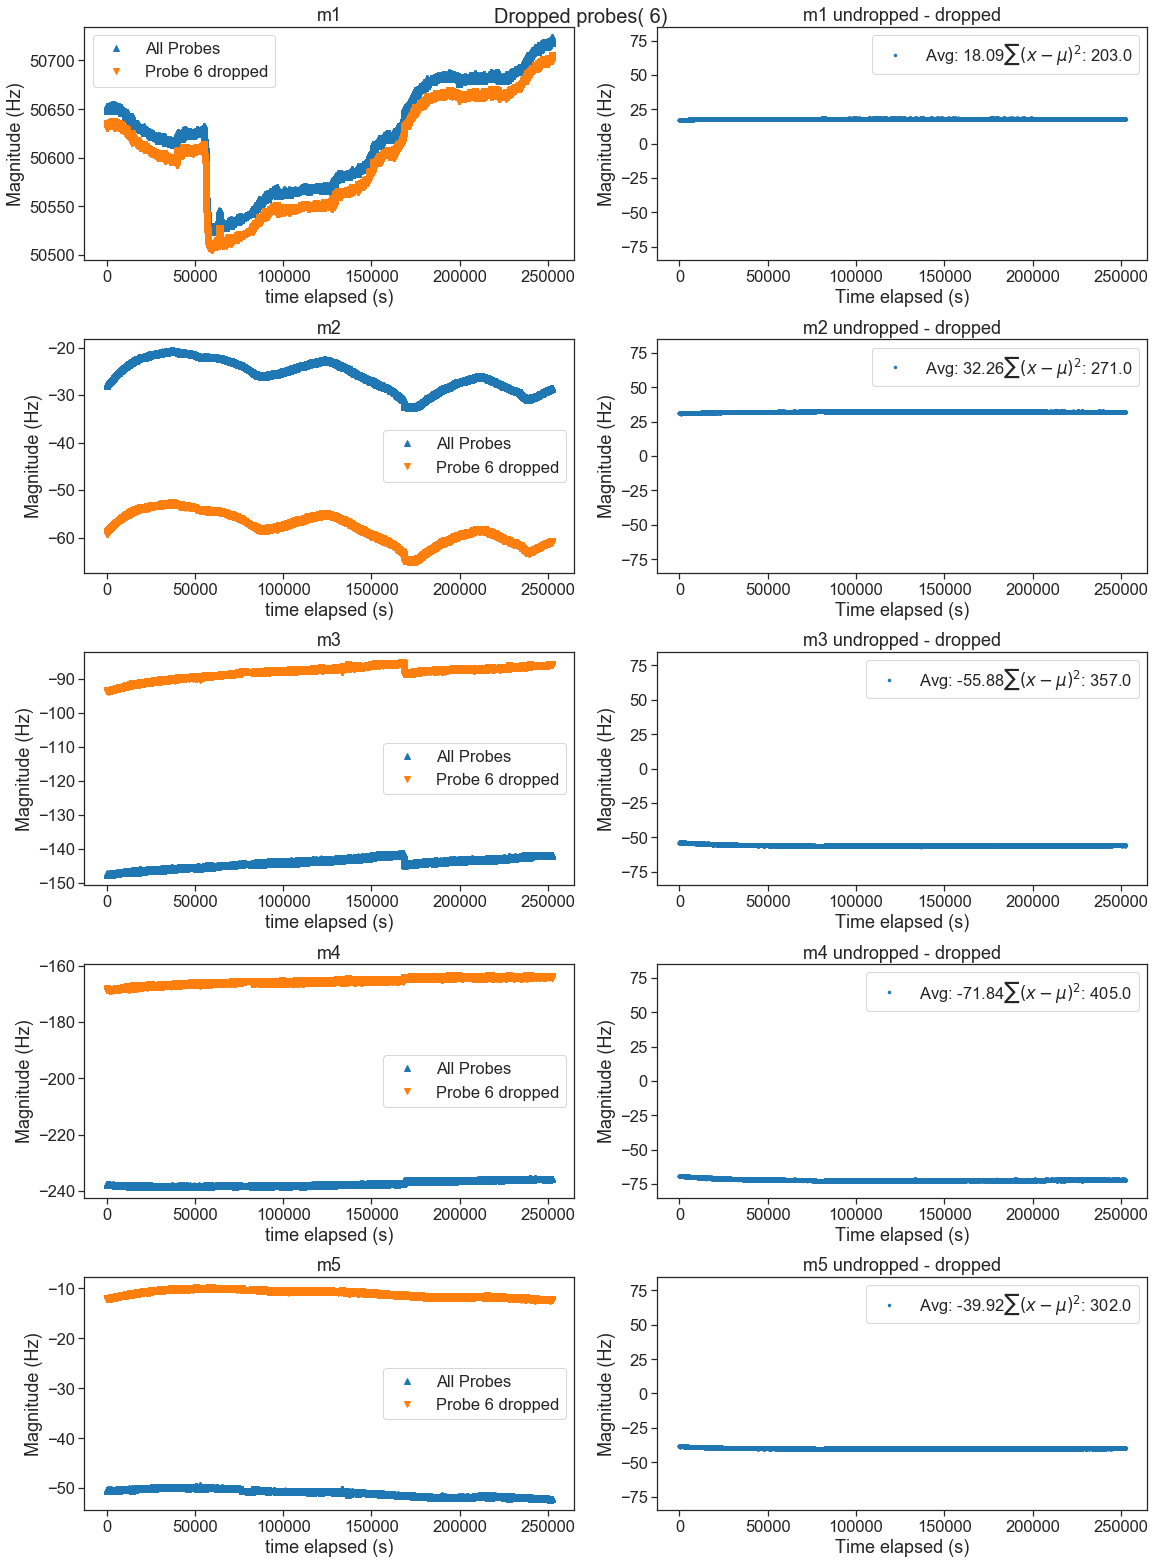

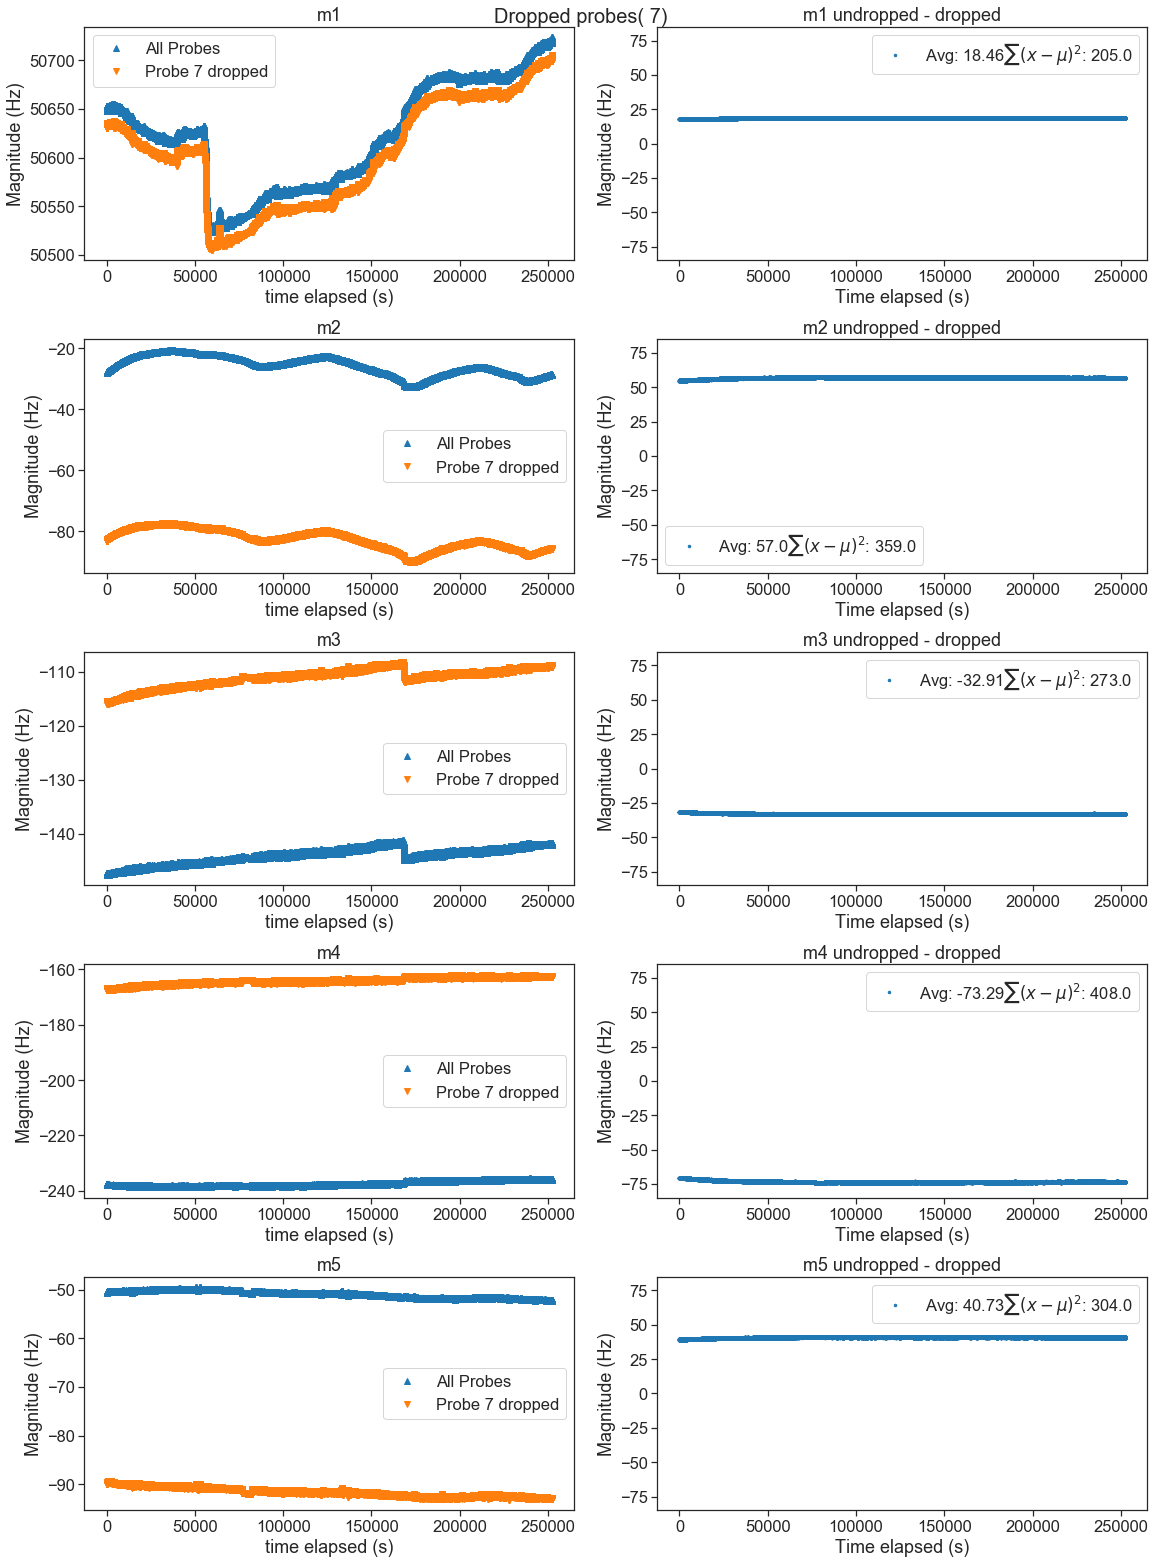

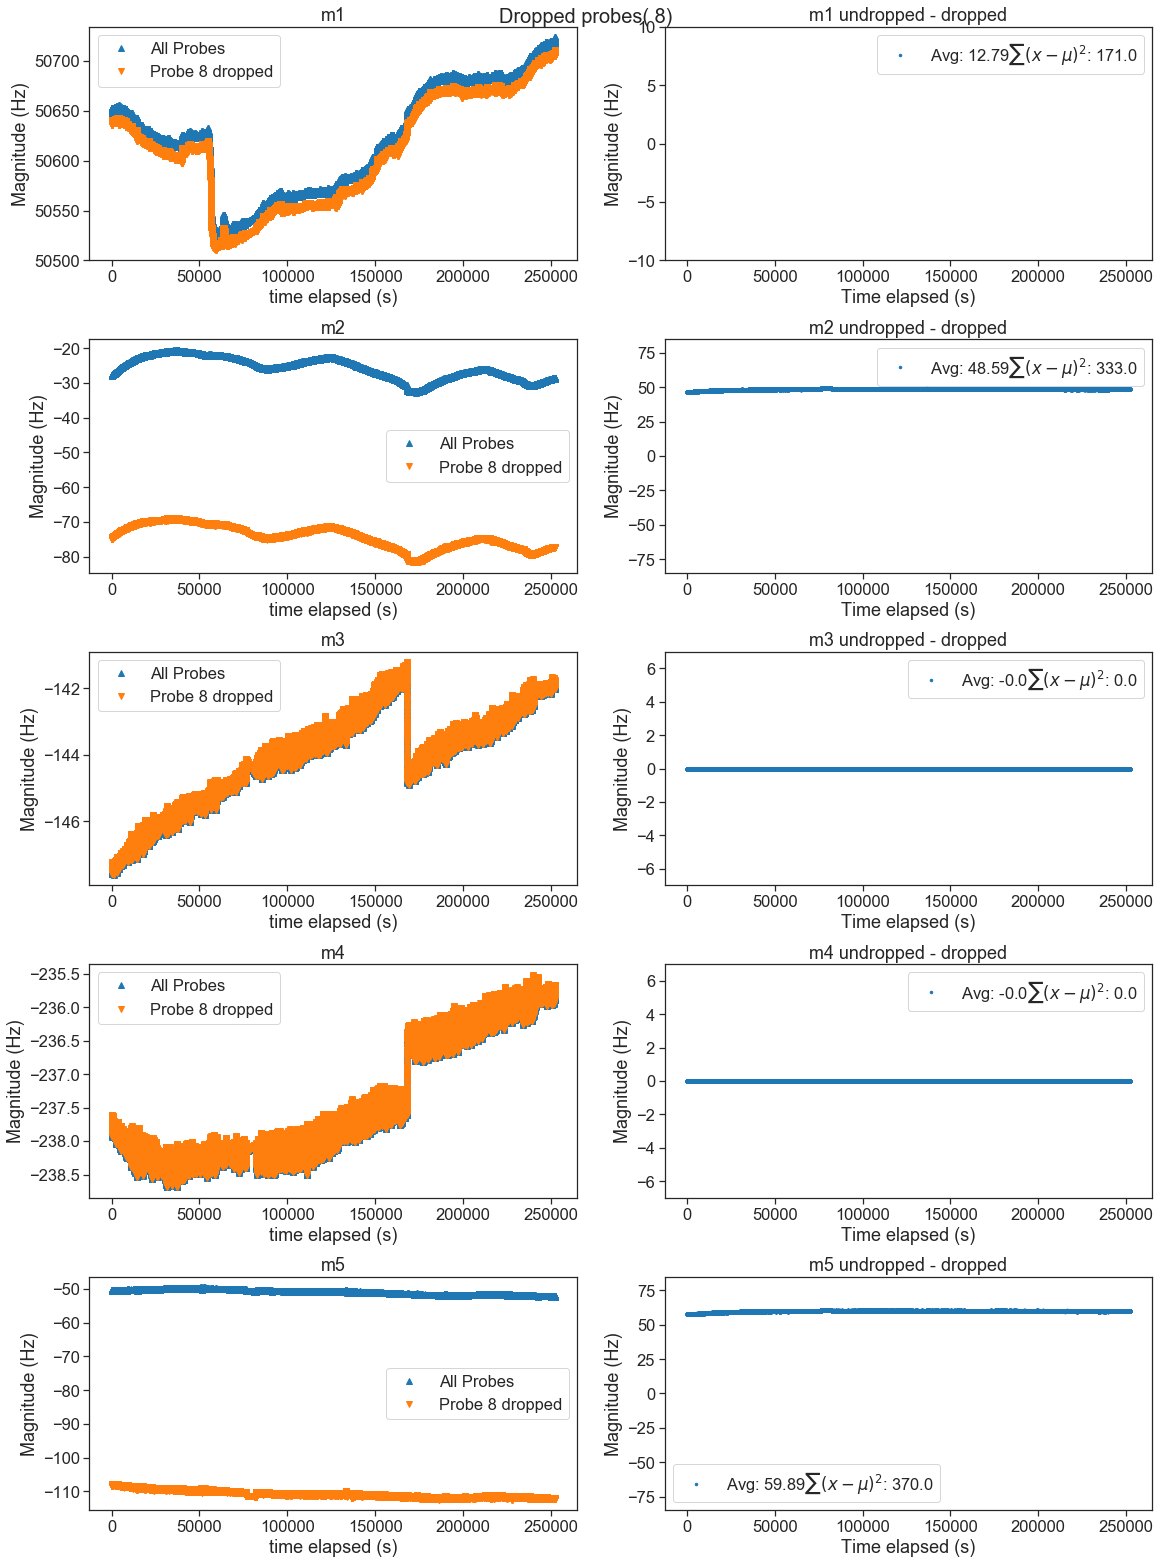

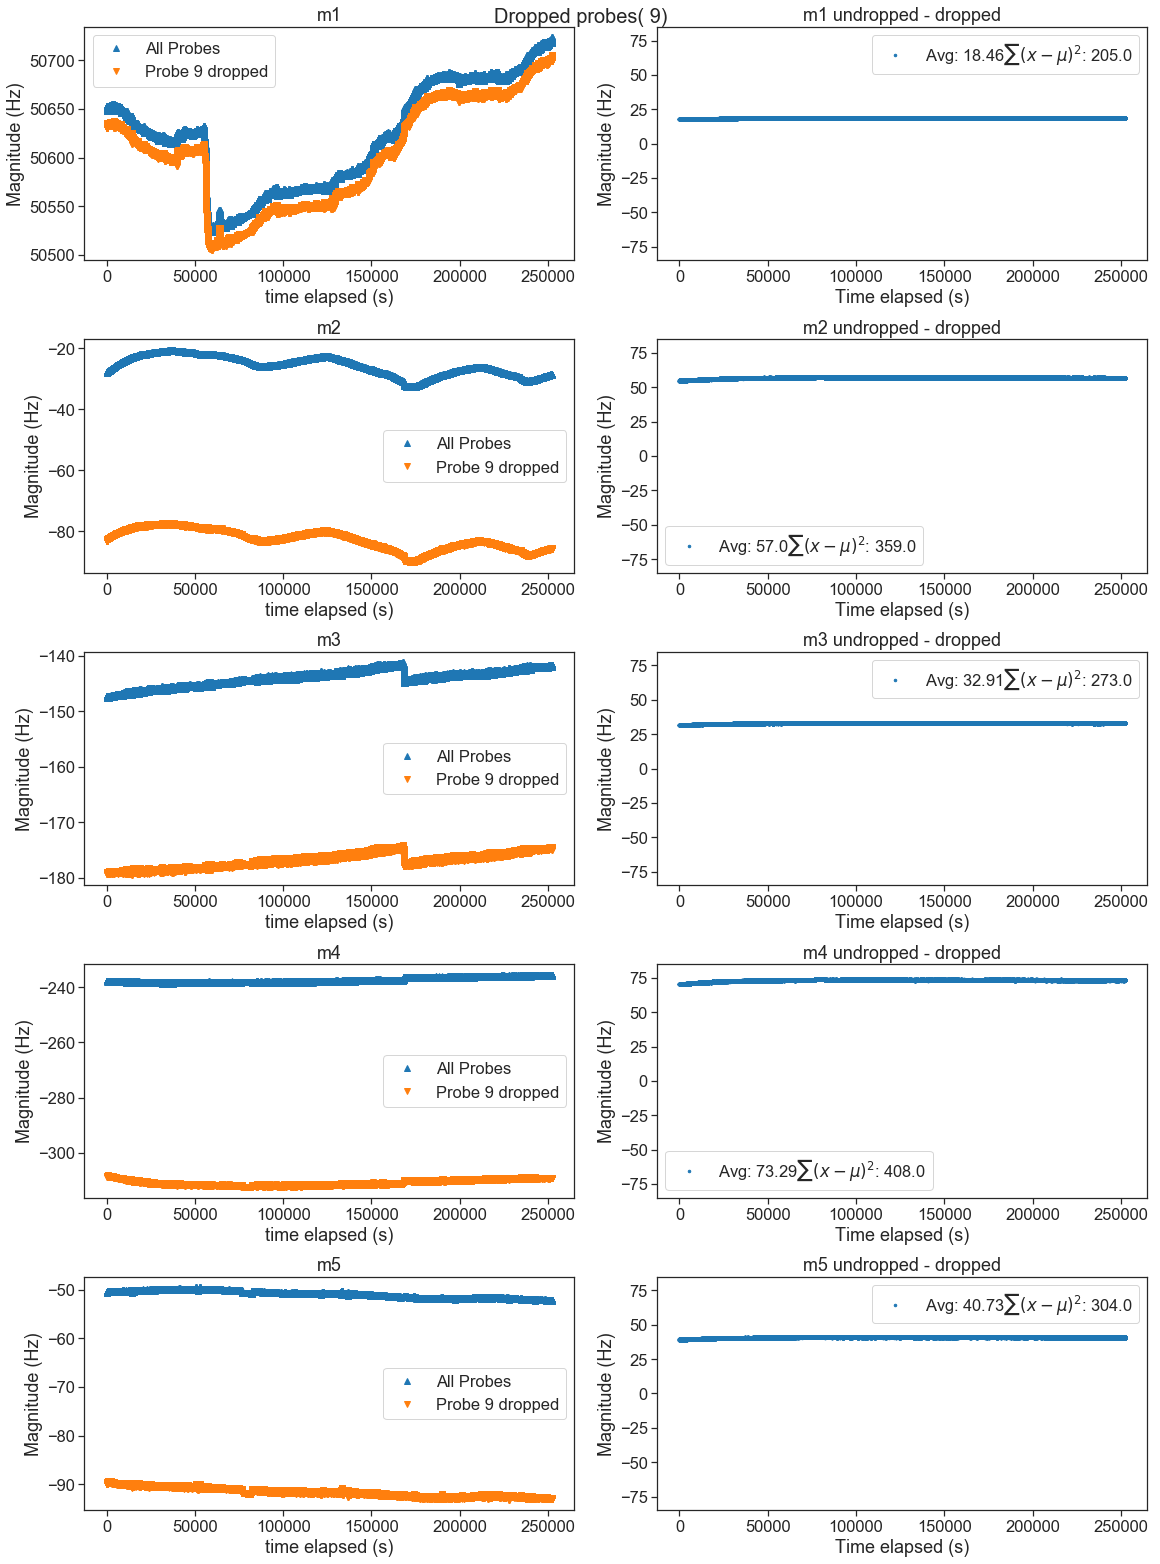

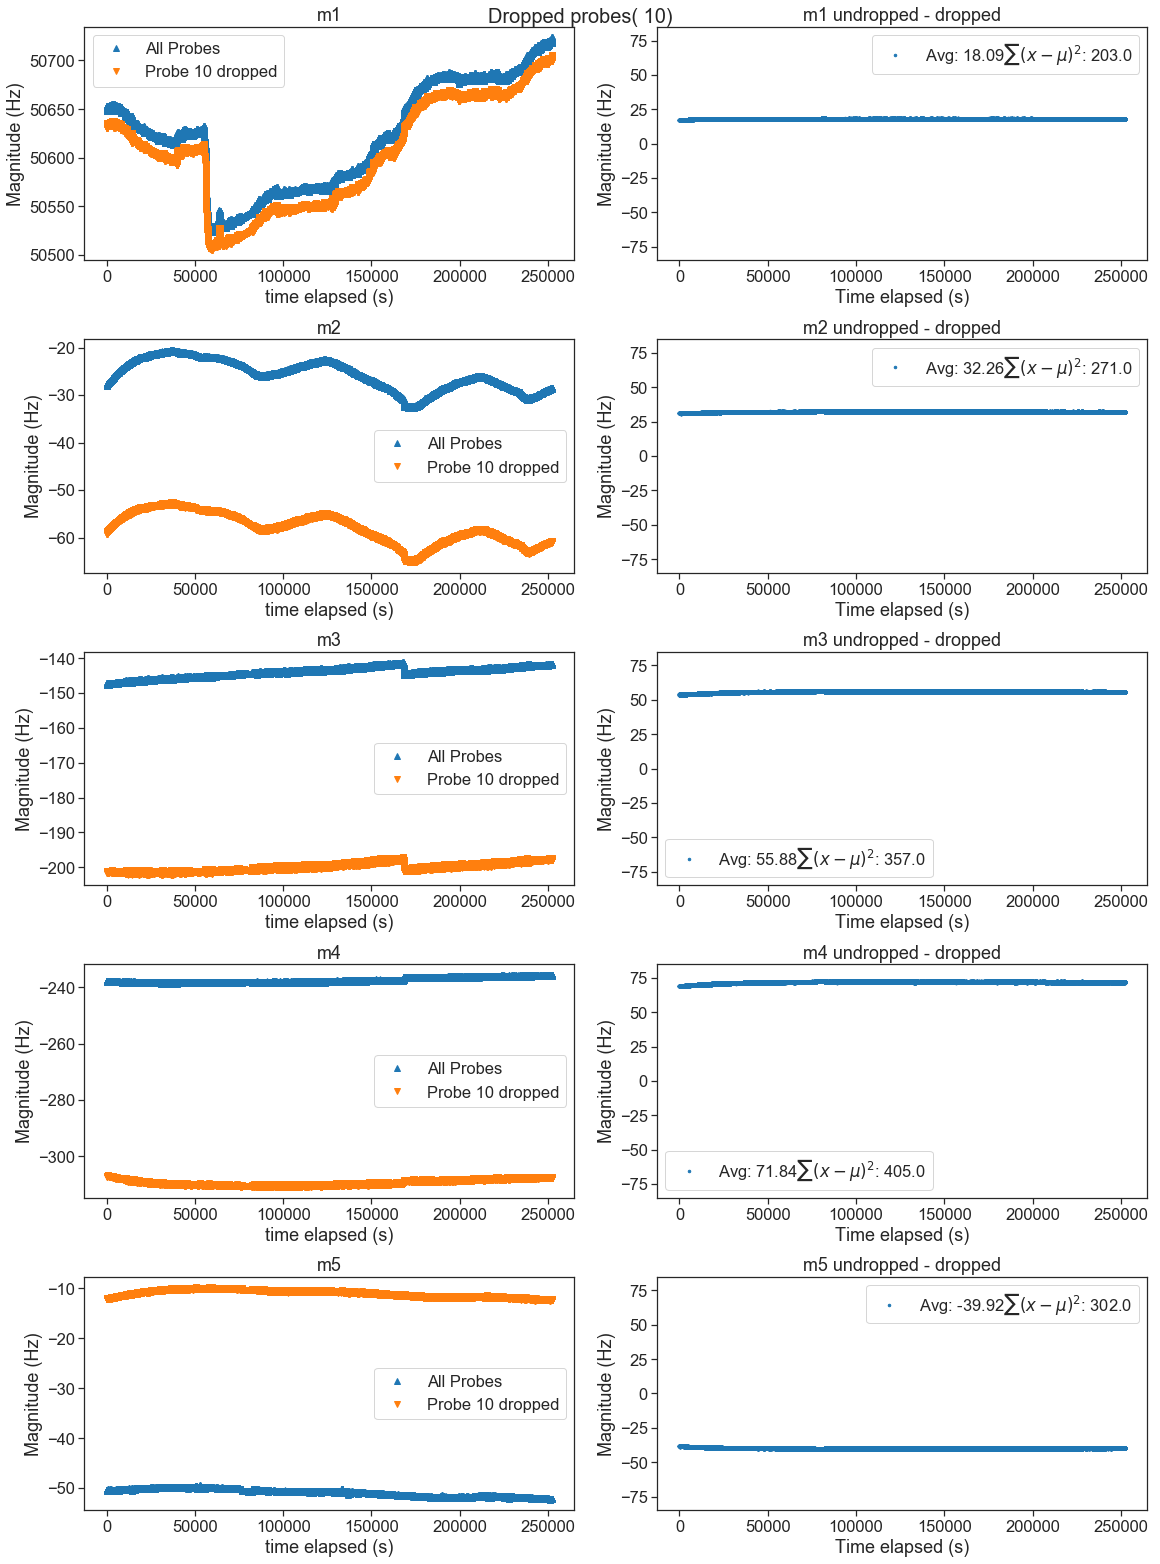

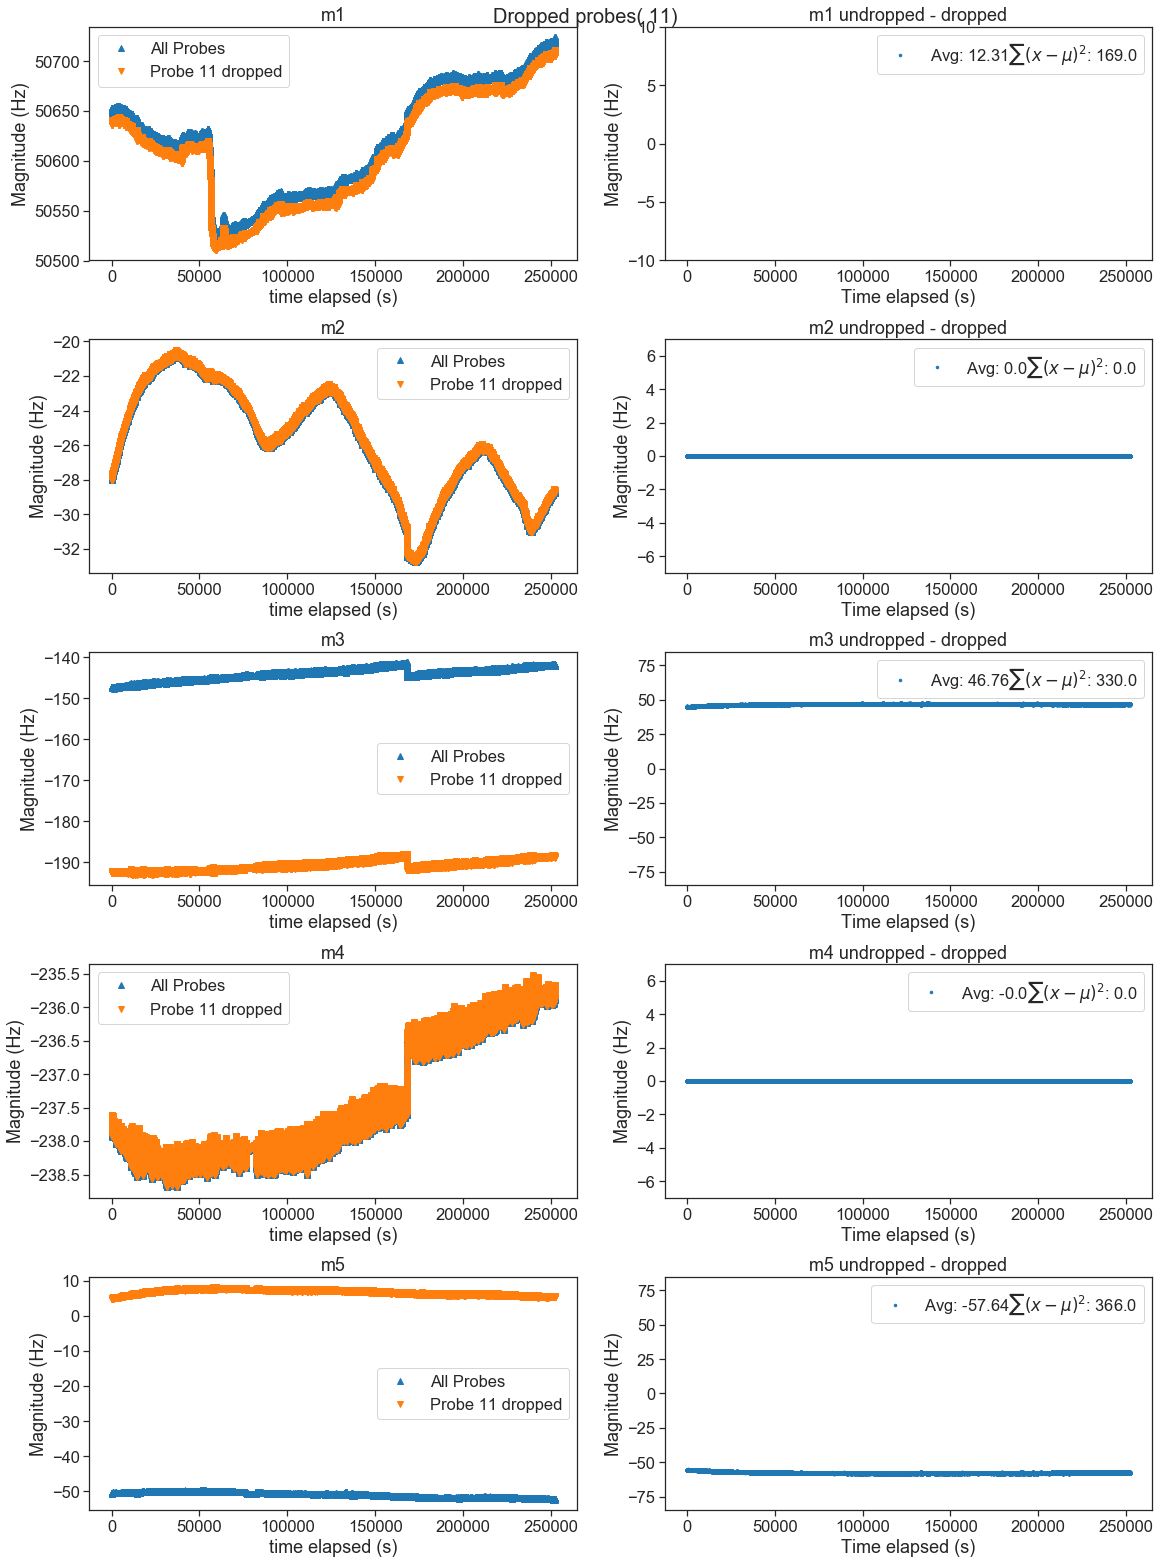

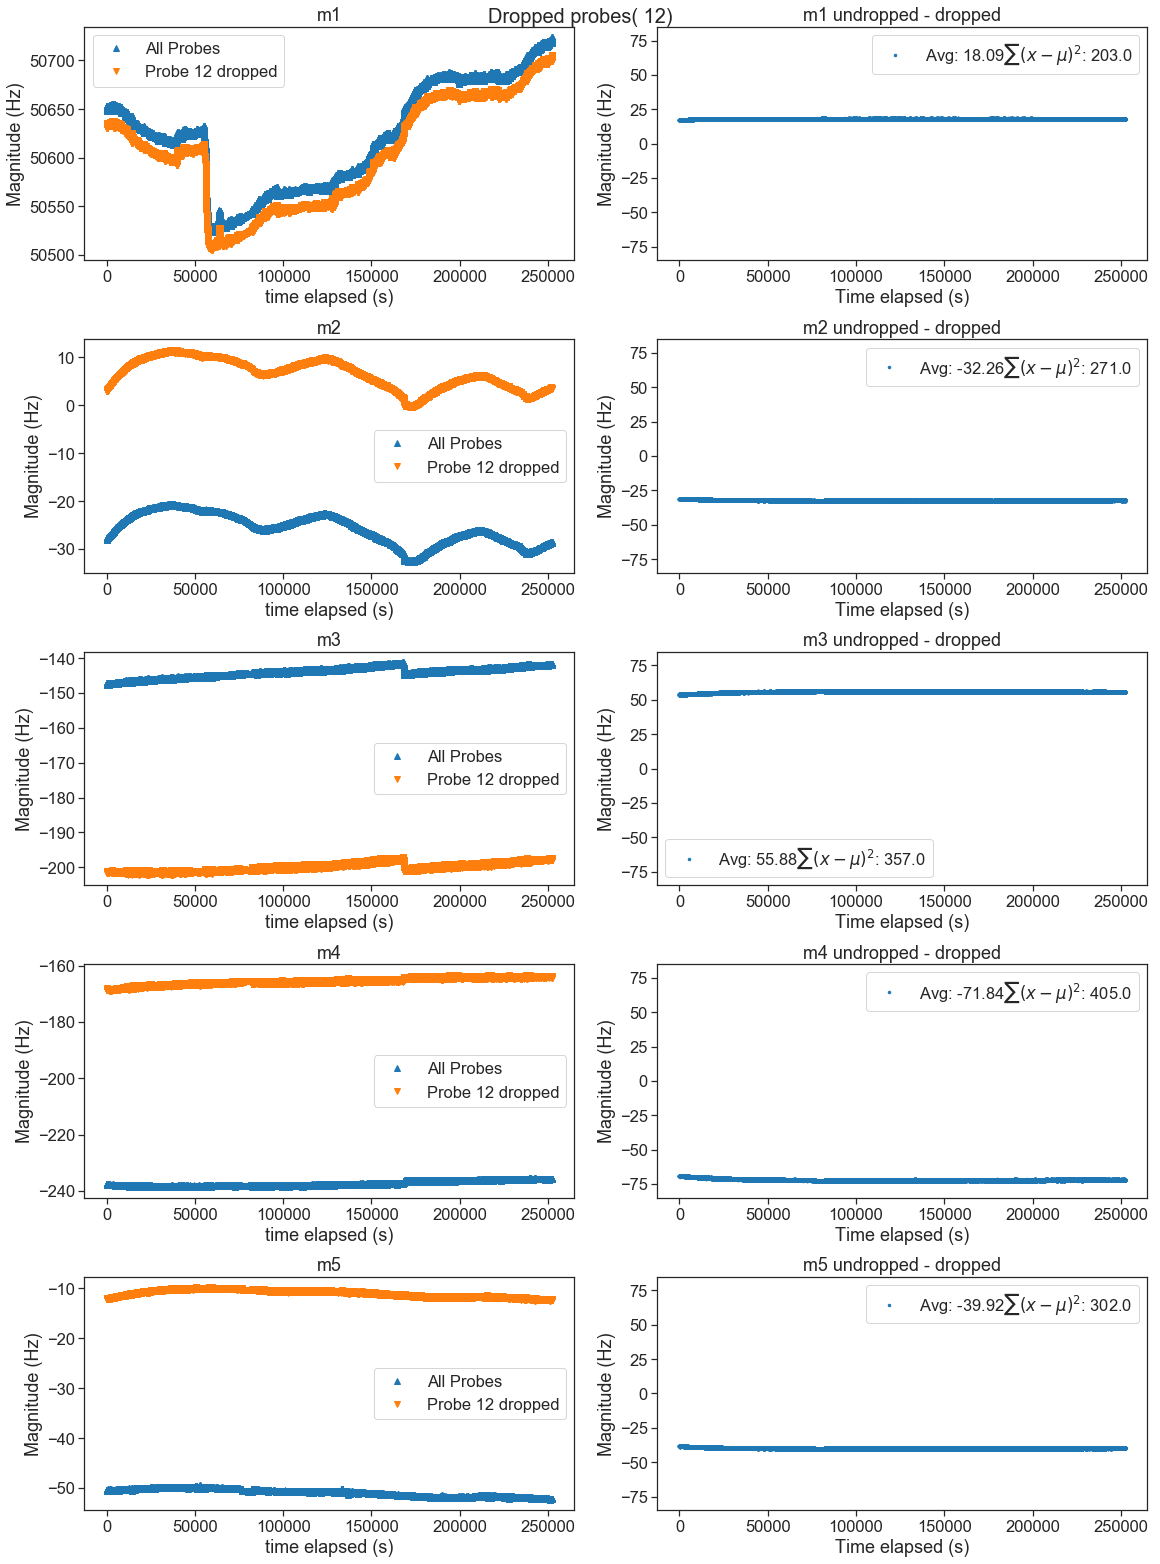

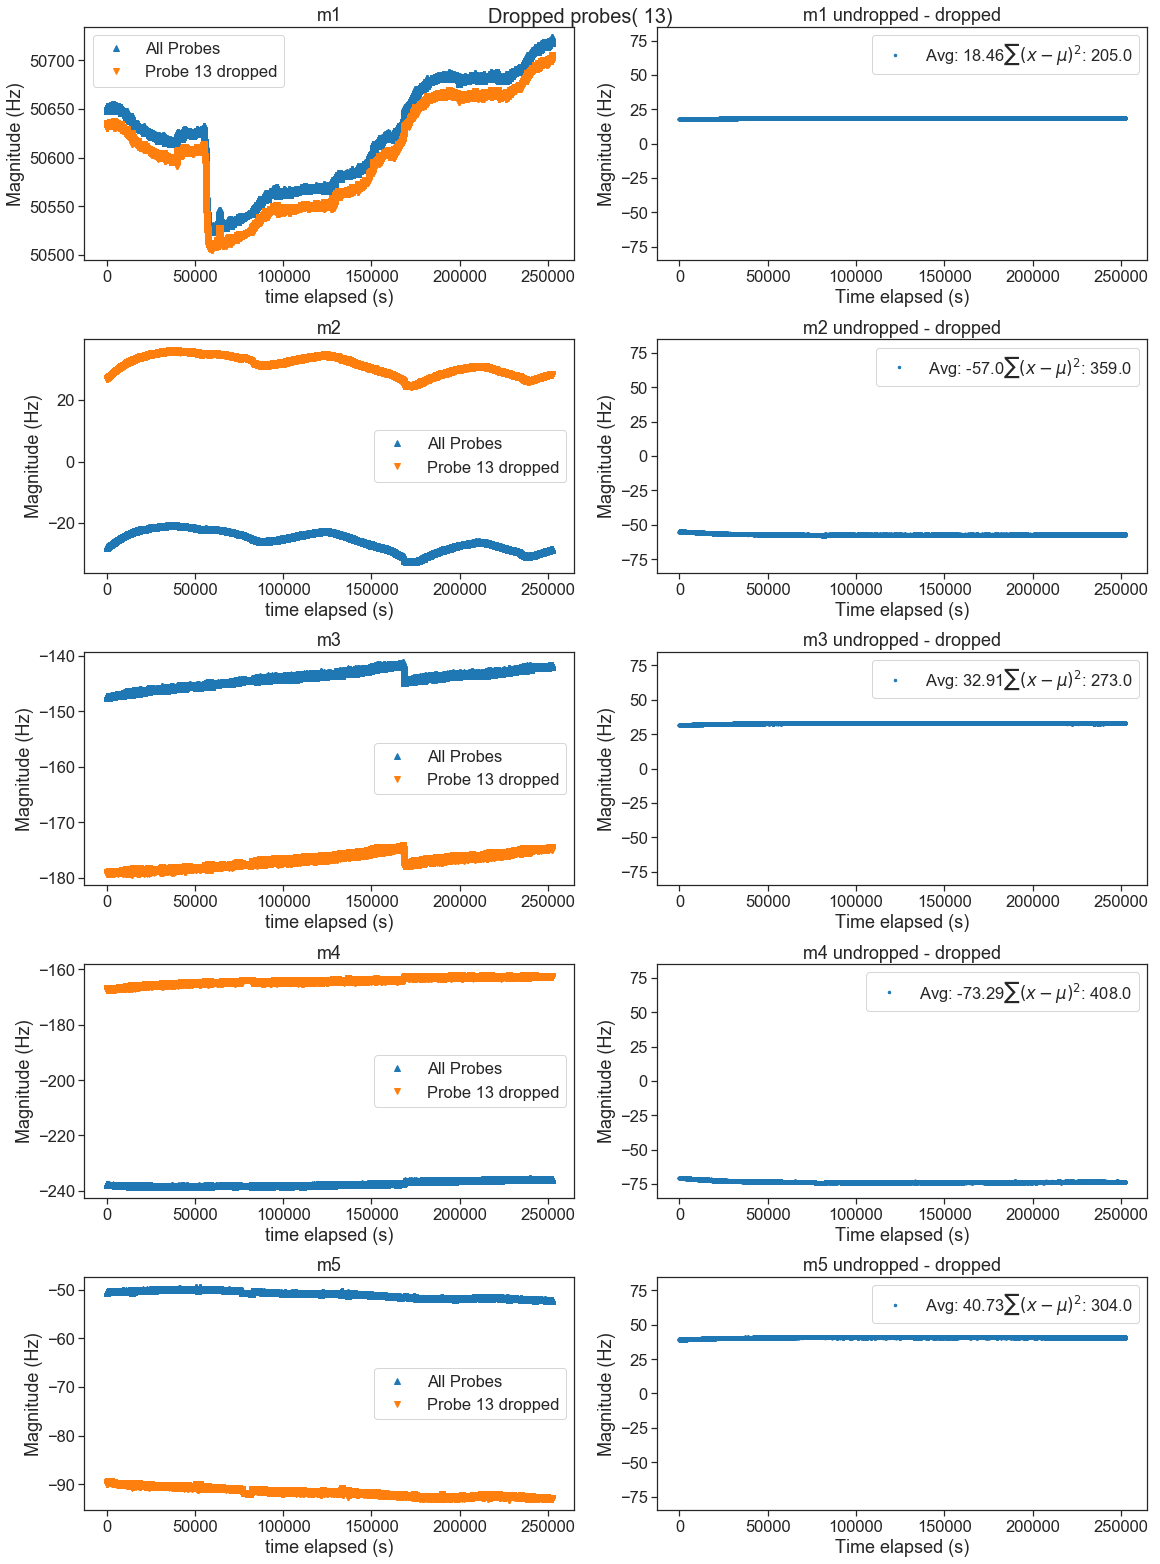

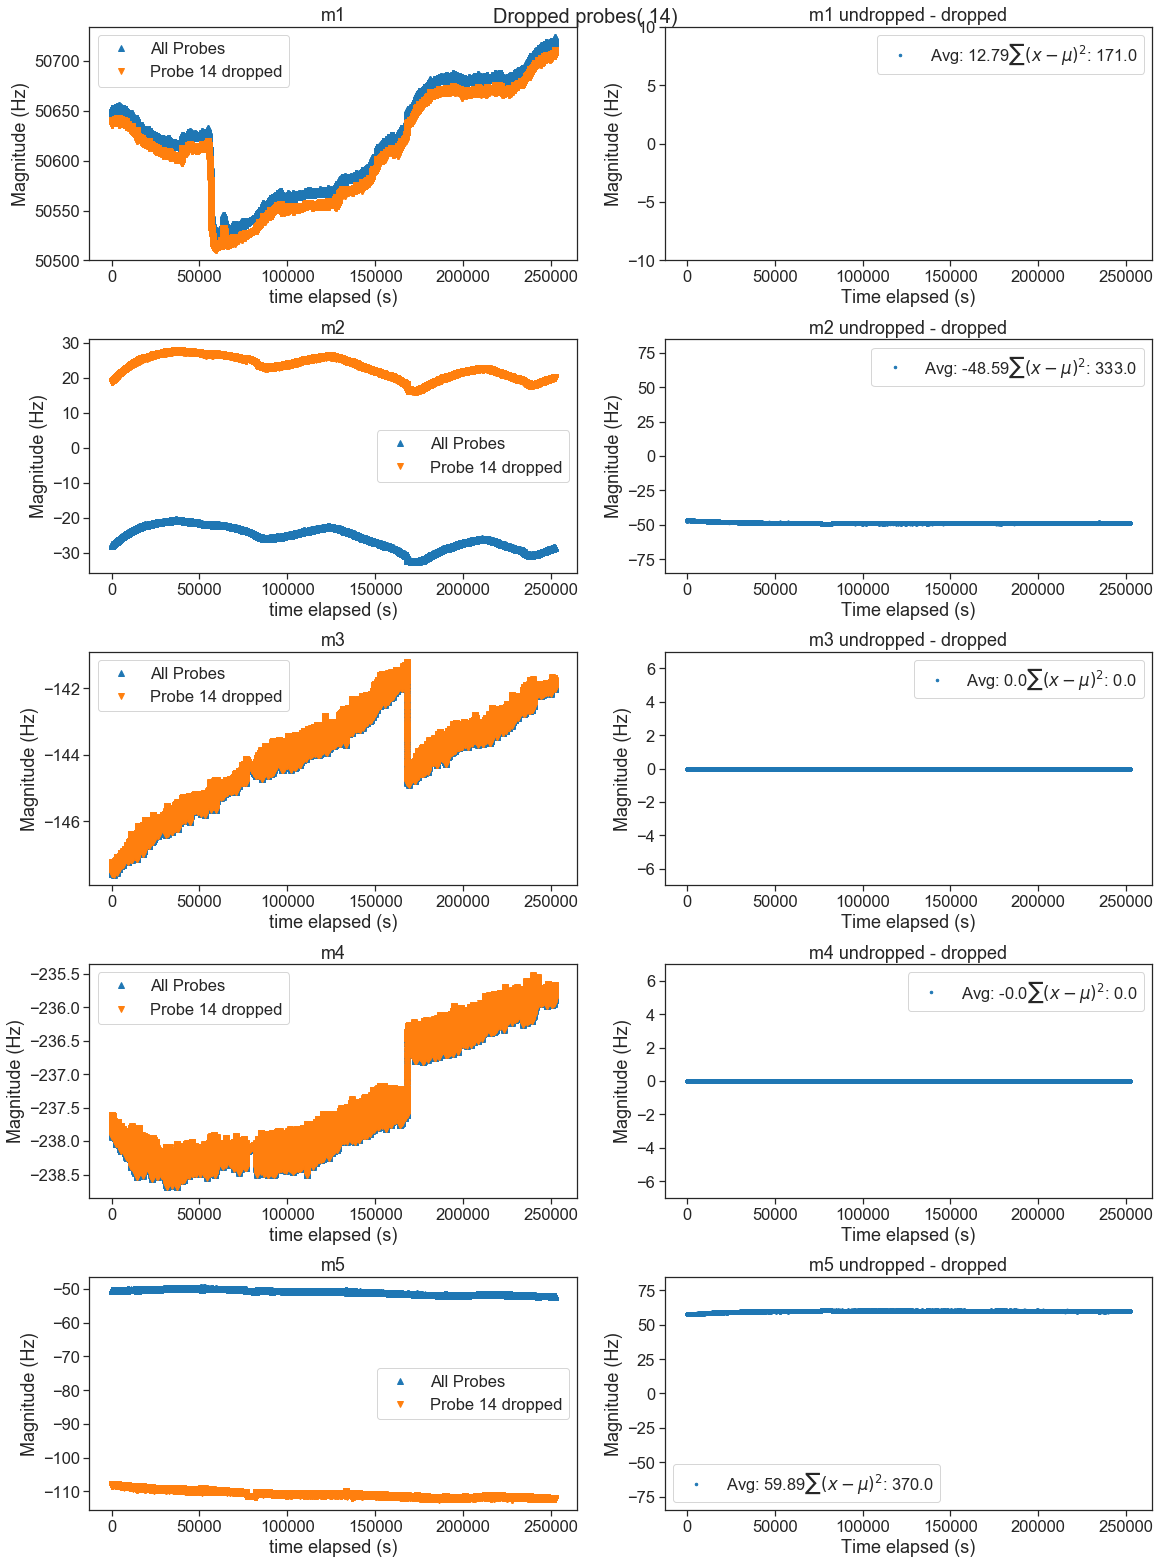

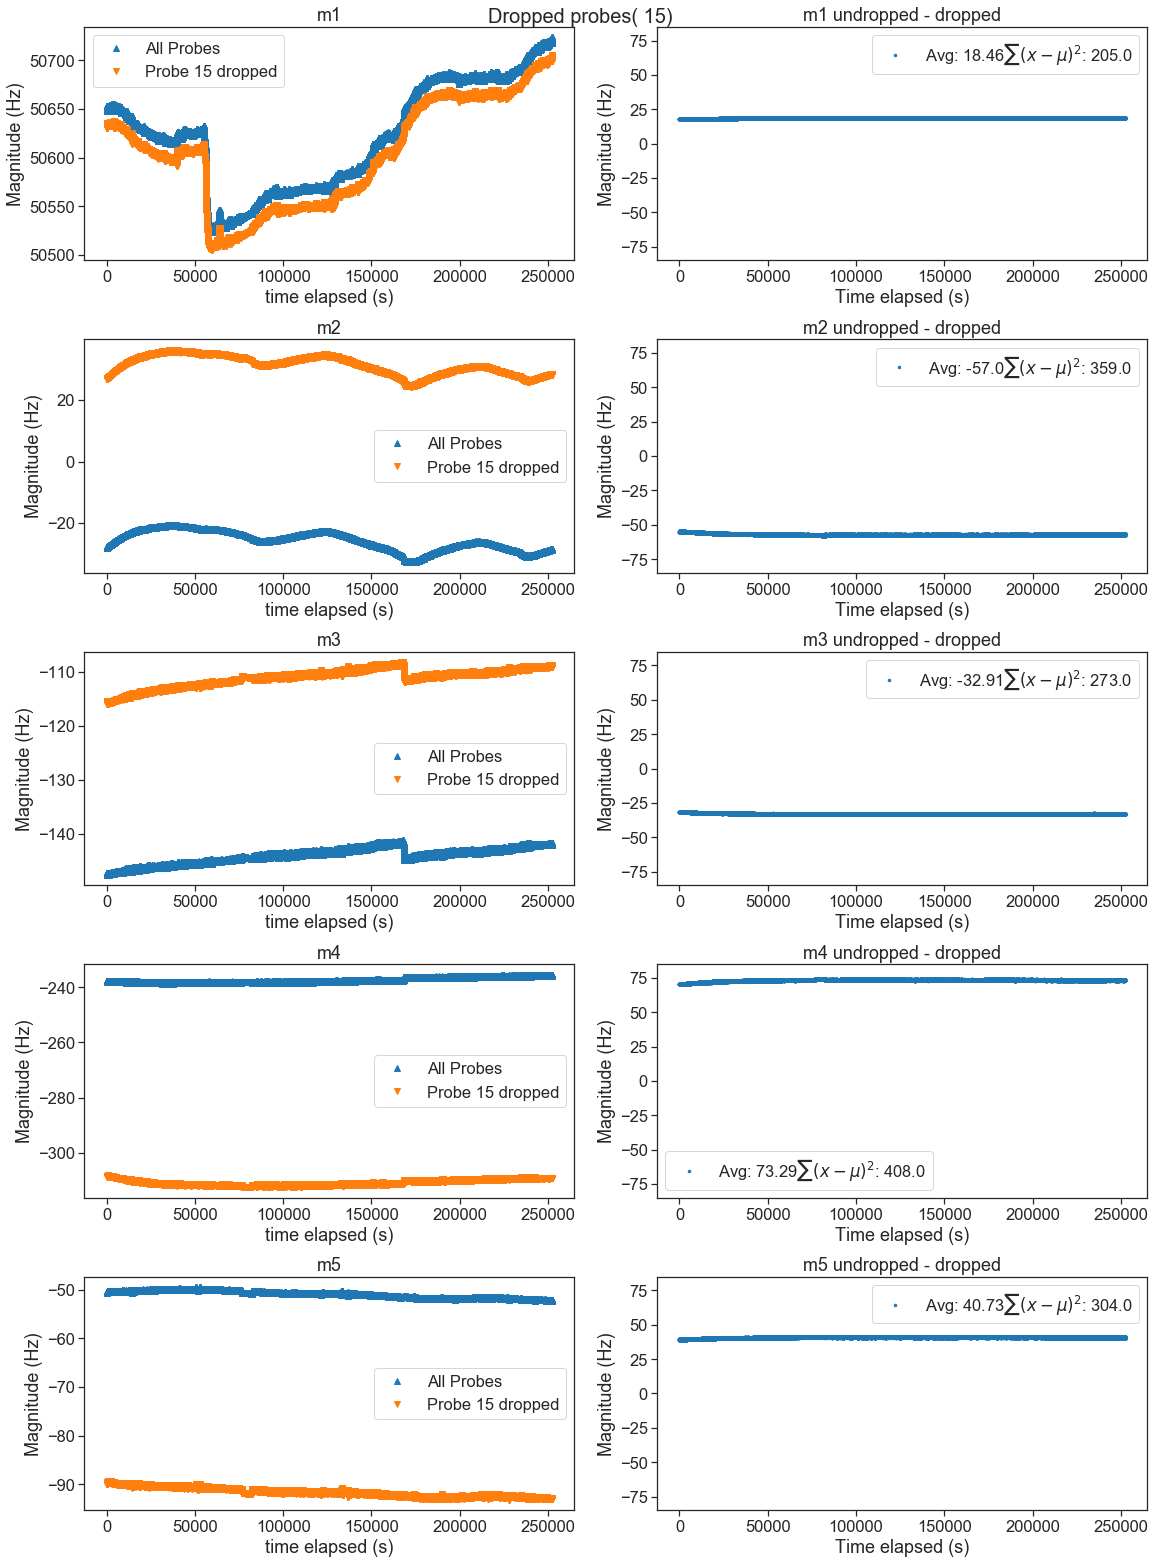

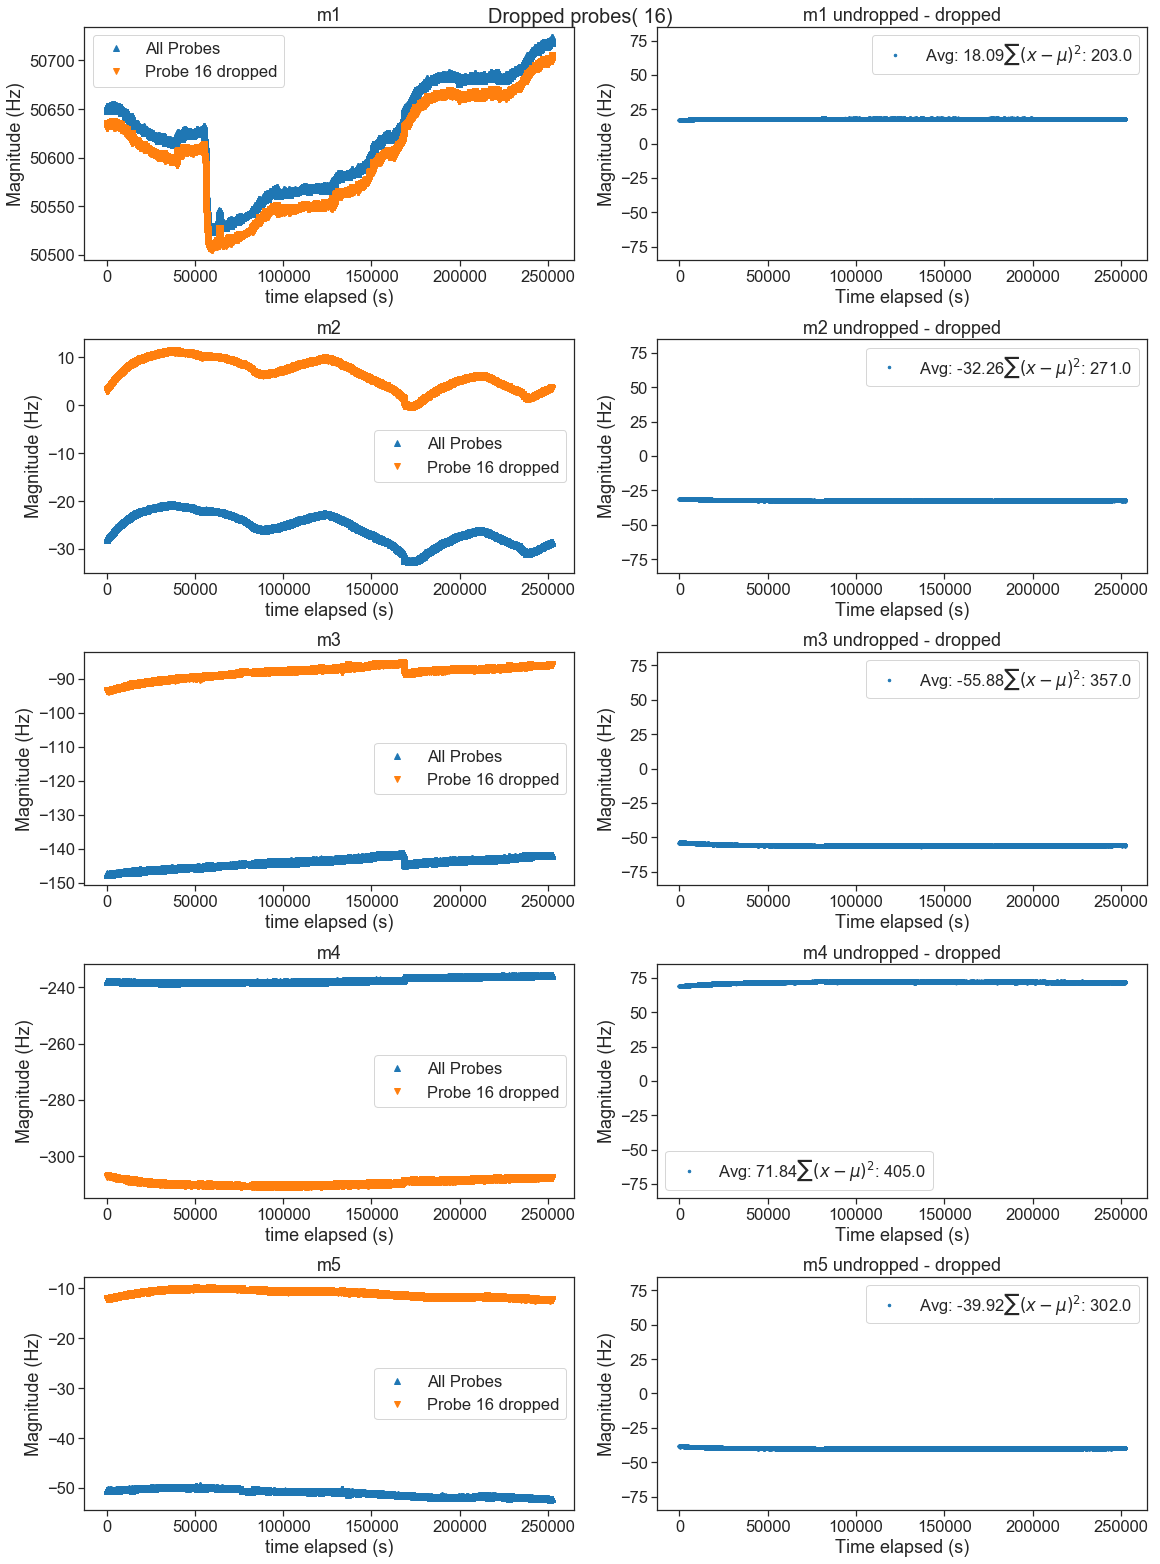

In [15]:
diffMax = []
for j in range(len(PossibleDropsN)):
    fig, axs = plt.subplots(5, 2, constrained_layout=True)
    fig.set_figheight(11*2)
    fig.set_figwidth(8*2)
    for i in range(5):
        M = len(trm_undropped[0])
        #diff = np.delete(trm_undropped[i] - trm_dropped[j,i], np.arange(M-100, M))
        diff = trm_undropped[i] - trm_dropped[j,i]
        t = np.delete(T-T[0], np.arange(M-100, M))
        axs[i,0].plot(T-T[0], trm_undropped[i], '^', label = "All Probes")
        axs[i,0].plot(T-T[0], trm_dropped[j,i], 'v', label = "Probe "+str(j)+" dropped")
        axs[i,0].set_xlabel(r'time elapsed (s)')
        axs[i,0].set_ylabel('Magnitude (Hz)')
        #plt_unix_time_to_CST(axs[i, 0])
        axs[i,0].legend()
        axs[i,0].set_title('m' + str(i+1))
        
        #t - t[0]
        axs[i,1].plot(T - T[0], diff, '.', markersize = 5, label = 'Avg: ' + str(round(np.average(diff),2))\
                     + r"$\sum (x-\mu)^2$: " + str(round(np.sqrt(np.std(diff)*len(diff)))))
        axs[i,1].set_xlabel(r'Time elapsed (s)')
        axs[i,1].set_ylabel('Magnitude (Hz)')
        #plt_unix_time_to_CST(axs[i, 1])
        axs[i,1].legend()
        axs[i,1].set_title('m' + str(i+1) + ' undropped - dropped')
        axs[i,1].set_ylim(-10,10)
        if(abs(max(diff)) < 7.5):
            axs[i,1].set_ylim(-7,7)
        if(abs(max(diff)) > 15):
            axs[i,1].set_ylim(-85,85)
        diffMax.append(max(diff))
    fig.suptitle(DropsToLabel(PossibleDropsN[j]), fontsize = 20)
    plt.show()
    #fig.savefig(path + "/1Drop_" + DropsToLabel(PossibleDropsN[j]) + ".png")

In [ ]:
diffs = np.array(diffMax)
print(diffs)
print(max(abs(diffs)))

In [ ]:
interp = helper.root_to_pandas([4265],\
                                  prefix = r'//data1/newg2/DataProduction/Offline/ArtTFSDir/v9_21_05_dev/FieldPlainRootOutput_',\
                                  tr_run = True)
#[5054]
print(interp['tr_phi'].to_numpy())
plt.plot(interp['tr_phi'].to_numpy())
plt.yticks(np.linspace(0, 360, 7))
plt.grid()
plt.show()

In [ ]:
interp = pd.read_hdf('hdf5/superlong_2.h5')
#interp = helper.root_to_pandas([4584],\
#                                  prefix = r'//data1/newg2/DataProduction/Offline/ArtTFSDir/v9_21_05_dev/FieldPlainRootOutput_',\
#                                  tr_run = True)
print(interp['tr_phi'].to_numpy())
plt.plot(interp['tr_phi'].to_numpy())
plt.yticks(np.linspace(0, 360, 7))
plt.grid()
plt.show()

In [ ]:
interp = pd.read_hdf('hdf5/superlong_1.h5')
#interp = helper.root_to_pandas([4584],\
#                                  prefix = r'//data1/newg2/DataProduction/Offline/ArtTFSDir/v9_21_05_dev/FieldPlainRootOutput_',\
#                                  tr_run = True)
print(interp['tr_phi'].to_numpy())
plt.plot(interp['tr_phi'].to_numpy())
plt.yticks(np.linspace(0, 360, 7))
plt.grid()
plt.show()